In [1]:
#import non tensorflow libraries
import matplotlib.pyplot as plt
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import pathlib
import IPython.display as display

#import tensorflow libraries
import tensorflow as tf
from tensorflow import keras
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory
import tensorflow.keras.layers as tfl
import keras_cv
import pickle

2024-04-14 22:51:09.550427: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-14 22:51:09.550718: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-14 22:51:09.711254: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
BATCH_SIZE = 16
IMG_SIZE = (224, 224)
train_dataset = image_dataset_from_directory('/kaggle/input/preprocessing-koa-dataset-binary/train/',
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)
validation_dataset = image_dataset_from_directory('/kaggle/input/preprocessing-koa-dataset-binary/val/',
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)

Found 7304 files belonging to 2 classes.
Found 826 files belonging to 2 classes.


tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(1, shape=(), dtype=int32)
tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(1, shape=(), dtype=int32)
tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(0, shape=(), dtype=int32)


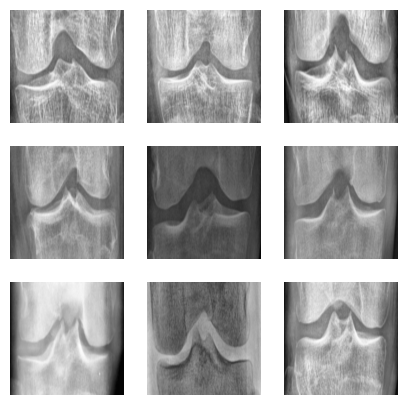

In [3]:
class_names = train_dataset.class_names

plt.figure(figsize=(5, 5))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        print(labels[i])
#         plt.title(class_names[labels[i]])
        plt.axis("off")

In [4]:
def data_augmenter():
    '''
    Create a Sequential model composed of 2 layers
    Returns:
        tf.keras.Sequential
    '''
    data_augmentation = tf.keras.Sequential([
        tf.keras.layers.RandomFlip(mode="horizontal"),
        tf.keras.layers.RandomZoom(0.1)
    ])

    return data_augmentation

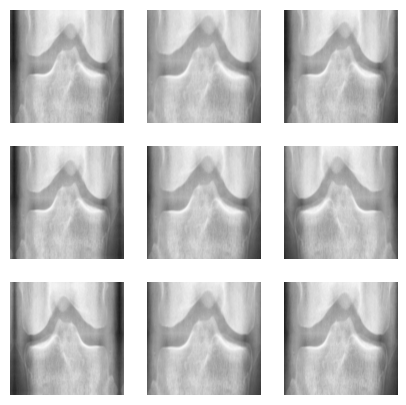

In [5]:
data_augmentation = data_augmenter()

for image, _ in train_dataset.take(1):
    plt.figure(figsize=(5, 5))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

In [6]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = keras_cv.models.ImageClassifier.from_preset(
    "resnet50_v2_imagenet_classifier",
)
# base_model = tf.keras.applications.ResNet50(input_shape=IMG_SHAPE,
#                                                include_top=True,
#                                                weights='imagenet')

Attaching 'config.json' from model 'keras/resnetv2/keras/resnet50_v2_imagenet_classifier/2' to your Kaggle notebook...
Attaching 'config.json' from model 'keras/resnetv2/keras/resnet50_v2_imagenet_classifier/2' to your Kaggle notebook...
Attaching 'model.weights.h5' from model 'keras/resnetv2/keras/resnet50_v2_imagenet_classifier/2' to your Kaggle notebook...


In [7]:
base_model.trainable = True

In [8]:
model = tf.keras.Sequential()
model.add(base_model)
model.add(tf.keras.layers.Dense(320, activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

In [9]:
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.001,momentum=0.9),
      loss =tf.keras.losses.BinaryCrossentropy(from_logits=False),
      metrics=['accuracy',tf.keras.metrics.AUC()])
print(model.summary())

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ image_classifier                │ ?                      │    25,613,800 │
│ (ImageClassifier)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,613,800 (97.71 MB)

 Trainable params: 25,568,360 (97.54 MB)

 Non-trainable params: 45,440 (177.50 KB)

None


In [10]:
epochs = 5

# Reduce learning rate when there is a change lesser than <min_delta> in <val_accuracy> for more than <patience> epochs
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_accuracy',
                                                 mode = 'max',
                                                 min_delta = 0.01,
                                                 patience = 3,
                                                 factor = 0.25,
                                                 verbose = 1,
                                                 cooldown = 0,
                                                 min_lr = 0.00000001)

# Stop the training process when there is a change lesser than <min_delta> in <val_accuracy> for more than <patience> epochs
early_stopper = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy',
                                                 mode = 'max',
                                                 min_delta = 0.005,
                                                 patience = 10,
                                                 verbose = 1,
                                                 restore_best_weights = True)
checkpoint_filepath = 'checkpoints_resnet50_bin.model.keras'
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [11]:
class_weights = {0: 1.7345048682023272, 1: 2.3614613643711606}

In [12]:
history = model.fit(train_dataset,
                    class_weight = class_weights,
                    epochs=epochs,
                    validation_data = validation_dataset,
                    callbacks=[early_stopper, reduce_lr, model_checkpoint_callback])

Epoch 1/5
457/457 ━━━━━━━━━━━━━━━━━━━━ 7928s 17s/step - accuracy: 0.4763 - auc: 0.4976 - loss: 1.3866 - val_accuracy: 0.4189 - val_auc: 0.5342 - val_loss: 0.6940 - learning_rate: 0.0010
Epoch 2/5
457/457 ━━━━━━━━━━━━━━━━━━━━ 7805s 17s/step - accuracy: 0.4759 - auc: 0.5143 - loss: 1.3866 - val_accuracy: 0.4177 - val_auc: 0.5069 - val_loss: 0.6940 - learning_rate: 0.0010
Epoch 3/5
457/457 ━━━━━━━━━━━━━━━━━━━━ 7768s 17s/step - accuracy: 0.4582 - auc: 0.5182 - loss: 1.3860 - val_accuracy: 0.4177 - val_auc: 0.5244 - val_loss: 0.6941 - learning_rate: 0.0010
Epoch 4/5
457/457 ━━━━━━━━━━━━━━━━━━━━ 0s 17s/step - accuracy: 0.5004 - auc: 0.5332 - loss: 1.3860 
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
457/457 ━━━━━━━━━━━━━━━━━━━━ 7907s 17s/step - accuracy: 0.5005 - auc: 0.5332 - loss: 1.3860 - val_accuracy: 0.4165 - val_auc: 0.5316 - val_loss: 0.6940 - learning_rate: 0.0010
Epoch 5/5
457/457 ━━━━━━━━━━━━━━━━━━━━ 7803s 17s/step - accuracy: 0.4470 - auc: 0.5462 - l

In [13]:
with open('trainHistoryDict', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

In [14]:
test_dataset = image_dataset_from_directory('/kaggle/input/preprocessing-koa-dataset-binary/test/',
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)

Found 1656 files belonging to 2 classes.


In [15]:
results = model.evaluate(test_dataset)
predictions = model.predict(test_dataset)

104/104 ━━━━━━━━━━━━━━━━━━━━ 412s 4s/step - accuracy: 0.4271 - auc: 0.5871 - loss: 0.6932
104/104 ━━━━━━━━━━━━━━━━━━━━ 404s 4s/step


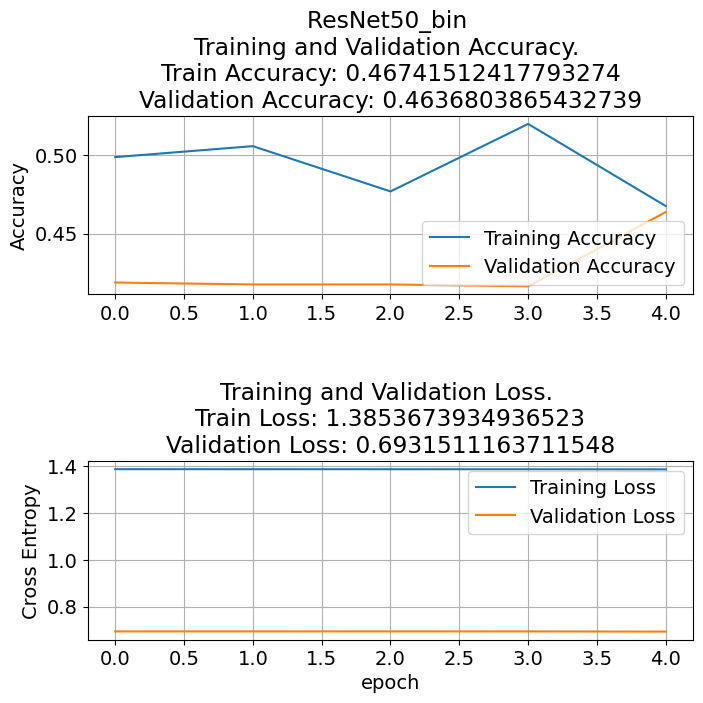

In [16]:
#get results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

#plot results
#accuracy
plt.figure(figsize=(8, 8))
plt.rcParams['figure.figsize'] = [16, 9]
plt.rcParams['font.size'] = 14
plt.rcParams['axes.grid'] = True
plt.rcParams['figure.facecolor'] = 'white'
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title(f'ResNet50_bin \nTraining and Validation Accuracy. \nTrain Accuracy: {str(acc[-1])}\nValidation Accuracy: {str(val_acc[-1])}')

#loss
plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title(f'Training and Validation Loss. \nTrain Loss: {str(loss[-1])}\nValidation Loss: {str(val_loss[-1])}')
plt.xlabel('epoch')
plt.tight_layout(pad=3.0)
plt.show()